In [1]:
## general
import datetime,copy,cf_units,os,sys,importlib,inspect
import numpy as np
import xarray as xr
from tqdm import tqdm
import datetime as dt

## statistics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal # to compute likelihood
from scipy.optimize import curve_fit, fmin, fminbound, minimize, rosen_der
from sklearn.preprocessing import StandardScaler
from scipy import special
from statsmodels.nonparametric.smoothers_lowess import lowess # lowess filter
from scipy.stats import percentileofscore


## plotting
import matplotlib.pyplot as plt
import numpy.ma as ma
import cartopy.crs as ccrs
from matplotlib.backends.backend_pdf import PdfPages

sys.path.append('distributions')

%load_ext autoreload
%autoreload 2

## Prepare some impact and gmt data
I have some functions for loading data\
In the end you just need one 2D xarray with all local impacts (*x*) and one matching 2D xarray with (smoothed) GMT (*gmt*)\
Dimensions:\
id_: and identifier of the form 'scenario_model_run' or similar (must contain a scenario)\
year: time (year)\
\
Here I use monthly tas over the region that was affected by the HW in Pakistan and India this year

In [10]:
import geopandas
shapeIndPak = geopandas.read_file('/work/uc1275/u290372/reversal/masks/shapefile/mask_shapev2.shp')
shapeIndPak = shapeIndPak.set_crs(3857,allow_override=True)
shapeIndPak = shapeIndPak.to_crs(4326)
shapeIndPak = shapeIndPak.geometry.translate(xoff = 65)

import _preprocessing
import _pre_ensemble

model='MPI-ESM1-2-LR'
imp = _pre_ensemble.ts_ensemble(indicator='tas', region_name='hw22SAS', shape_for_mask=shapeIndPak)
rev = _preprocessing.time_series_to_be_reversed(x=imp, model=model, scenarios=['ssp119','ssp126','ssp245','ssp370','ssp585'])

rev.load_data_peter(load_tmp=True)
rev._x.aggregateOverYear([6,7,8])
rev.finalize_preprocessing()
rev.get_gmt_smoo()
rev.subselect_period(1950,2100)
x2D = rev._x - 273.15
gmt2D = rev._gmt_smoo
print(x2D)

<xarray.DataArray 'data' (id_: 150, year: 151)>
array([[30.65178187, 31.45127223, 29.91752699, ..., 29.70519338,
        31.41031711, 31.6106485 ],
       [29.33509251, 30.80809855, 30.27120073, ..., 30.76219854,
        31.3113942 , 30.41226307],
       [31.19152998, 30.94653186, 30.44318847, ..., 30.04923213,
        33.39634804, 33.37139348],
       ...,
       [32.18966942, 30.74767407, 30.43837007, ..., 31.16037613,
        33.87141368, 31.90135383],
       [31.30790212, 31.0590484 , 30.88672417, ..., 33.95423556,
        34.15368608, 33.71834158],
       [30.00460197, 29.28487643, 30.99094074, ..., 32.92507598,
        33.18056523, 35.09430885]])
Coordinates:
    height   float64 2.0
  * id_      (id_) object 'ssp119_MPI-ESM1-2-LR_r10i1p1f1' ... 'ssp585_MPI-ES...
  * year     (year) int64 1950 1951 1952 1953 1954 ... 2096 2097 2098 2099 2100


## Get percentiles of impact values with respect to the natural variability of similar GMT levels

In [11]:
def prctl_x(x2D, window=10):
    '''
    x: the climate variable of interest
    window: the number of years over which distributions are assessed
    x and gmt have the same dimensions are xarrays (see above)
    '''
    if window % 2 != 0:
        window += 1
    window_half = int(0.5*window)
    prctls = x2D.copy() * 0
    scenarios = np.unique([smr.split('_')[0] for smr in x2D.id_.values])
    for scenario in scenarios:
        smrs = [smr for smr in x2D.id_.values if smr.split('_')[0] == scenario]
        for year in x2D.year.values:
            start = max(year-window_half,x2D.year.values[0])
            stop = min(year+window_half,x2D.year.values[-1]) 
            d = x2D.loc[smrs,start:stop].values.flatten()
            prctls.loc[smrs,year] = d.argsort().argsort()[window_half::(stop-start+1)] / (len(d)-1)
    prctls.values[prctls.values==1] = 0.999
    prctls.values[prctls.values==0] = 0.0001
    return prctls

In [12]:
import _get_percentile as _get_percentile; importlib.reload(_get_percentile)
phi_ = stats.norm.ppf(prctl_x(x2D=x2D, window=10))
phi2D = x2D.copy() * np.nan
phi2D[:,:] = phi_

## Fit a normal distribution where the mean depends linearly on GMT

### Background of the reversal idea:
Assuming that the impact variable is normally distributed, the quantile $\alpha$ of a given impact $y$ within the distribution of impacts for a $gmt$ would be:\
$\alpha = \phi[(y - \mu) /\sigma]$\
where $\phi$ is a standard normal CDF\
Assuming that $\mu$ is proportional to $gmt$:\
$\mu = \beta_1 \cdot gmt + \beta_2$\
We get:\
$gmt = \frac{y - \beta_2 - \phi^{-1}\sigma}{\beta_1}$

In [13]:
class dstr_obj():
    def __init__(self):
        self._param_names = inspect.getfullargspec(self.fit_function).args[2:]

    def add_and_clean_data(self, x, gmt, phi):
        # remove nans coming
        nans = x.copy() * 0
        for v in [x,gmt,phi]:
            nans += np.isfinite(v) == False

        self._x = x[nans==0]
        self._gmt = gmt[nans==0]
        self._phi = phi[nans==0]
        
    def store_parameters(self, popt):
        for i,p in enumerate(dstr._param_names):
            self.__dict__['_'+p] = popt[i]         
    
    def fit_function(self, X, b1, b2, c1):
        x,gmt = X
        return (x - b1 - b2*gmt) / (c1)        
    
    def fit_simple(self):
        b1 = self._x.mean()
        b2 = 1.1
        c1 = self._x.std()
        self._p0 = np.array([b1, b2, c1])
        
        popt = curve_fit(self.fit_function, (self._x, self._gmt), self._phi, self._p0)[0]
        self.store_parameters(popt)
        return popt
    
    def distr_for_given_gmt(self, gmt, N=100):
        mu = self._b1 + self._b2*gmt
        sigma = self._c1
        return np.random.normal(mu,sigma,N)
    
    def reversal_function(self, x_threshold, phi):
        '''
        x_threshold: an x value that corresponds to the phi percentile
        phi: a percentile
        '''
        alpha = stats.norm.ppf(phi)
        return (x_threshold - self._b1 - alpha*self._c1)/self._b2

In [14]:
dstr = dstr_obj()
dstr.add_and_clean_data(gmt=gmt2D.values.flatten(), x=x2D.values.flatten(), phi=phi2D.values.flatten())
popt = dstr.fit_simple()
for i,p in enumerate(dstr._param_names):
    print("%s: %s" %(p,popt[i])) 

b1: 30.50605393656799
b2: 0.5335608615672728
c1: 1.0277854109552635


### Using the fitted parameters of the normal distribution we can replicate impact distributions for all kinds of warming levels
Here these distributions are compared to what we would get using a time slicing approach

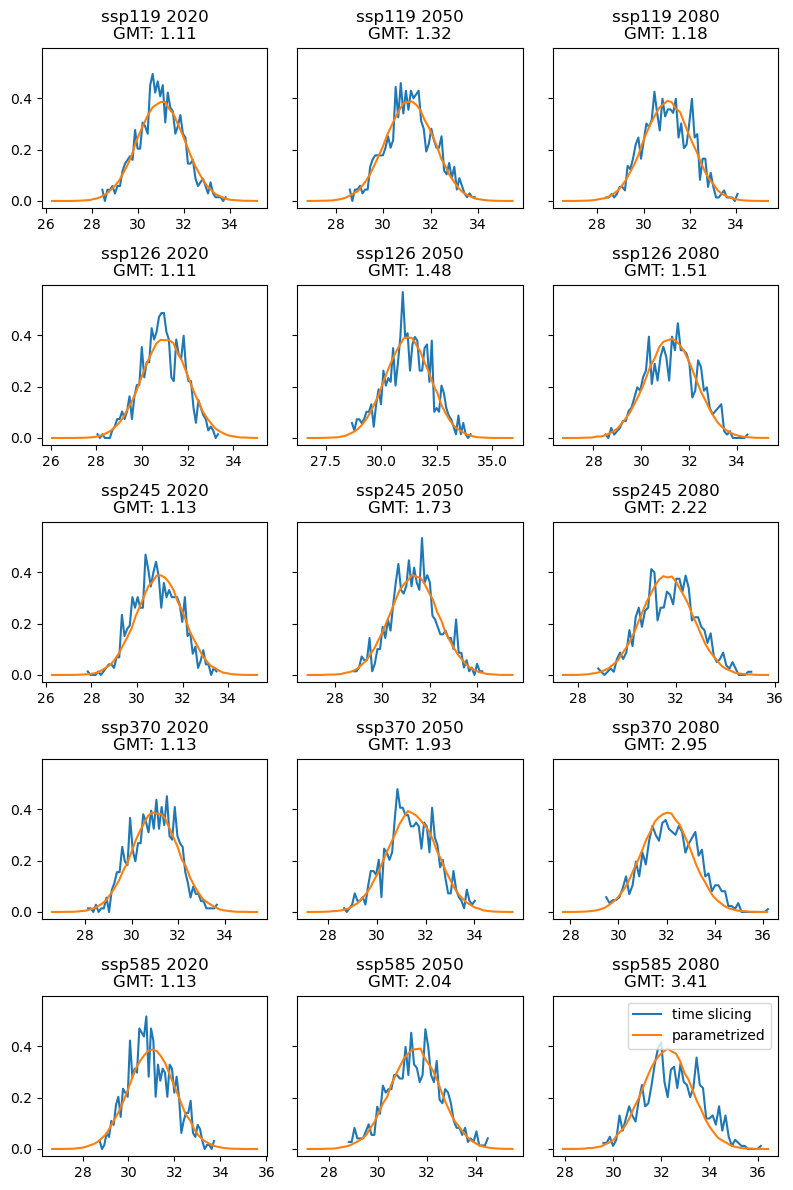

In [35]:
fig, axes = plt.subplots(ncols=3,nrows=5, figsize=(8,12), sharey=True)
i = 0
for scenario in ['ssp119','ssp126','ssp245','ssp370','ssp585'][:]:
    for year in [2020,2050,2080]:
        ax = axes.flatten()[i]
        i += 1
        
        ids_of_scenario = [smr for smr in gmt2D.id_.values if scenario in smr]
        gmt = gmt2D.loc[ids_of_scenario,year].values.mean()
        ax.set_title('%s %s\nGMT: %s' %(scenario, year, round(gmt,2)))

        time_slice = x2D.loc[ids_of_scenario,year-10:year+10].values.flatten()
        pdf,bins = np.histogram(time_slice, bins=50, density=True)
        ax.plot(bins[1:] - np.diff(bins,1), pdf, label='time slicing')
        
        sample = dstr.distr_for_given_gmt(gmt, N=100000)
        pdf,bins = np.histogram(sample[np.isfinite(sample)], bins=50, density=True)
        ax.plot(bins[1:] - np.diff(bins,1), pdf, label='parametrized')
ax.legend()
plt.tight_layout()

## Uncertainty of our fit
For now I implemented a bootstrapping where I randomly subselect half of the data points and estimate the parameters of the normal distribution 1000 times

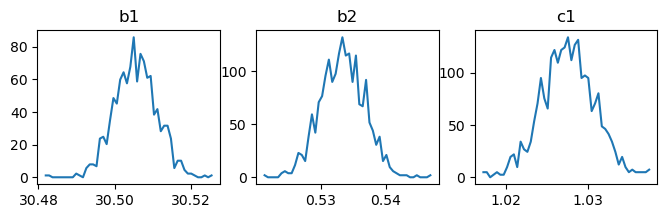

In [16]:
N_boot = 1000
popts = xr.DataArray(dims=['nBoot','param'], 
                     coords=dict(nBoot=np.arange(N_boot), param=dstr._param_names))

for i in range(N_boot):
    bs_ids = np.random.choice(len(x2D.values.flatten()), int(len(x2D.values.flatten())/2), replace=False)
    dstr = dstr_obj()
    dstr.add_and_clean_data(gmt=gmt2D.values.flatten()[bs_ids], x=x2D.values.flatten()[bs_ids], phi=phi2D.values.flatten()[bs_ids])
    popts.loc[i,:] = dstr.fit_simple()

fig, axes = plt.subplots(ncols=3,nrows=1, figsize=(8,2))
for ax,param in zip(axes.flatten(),dstr._param_names):
    p = popts.loc[:,param].values
    pdf,bins = np.histogram(p[np.isfinite(p)], bins=50, density=True)
    ax.plot(bins[1:] - np.diff(bins,1), pdf)
    ax.set_title(param)

### Reproduce the impact distribution for GMT=1.2°C

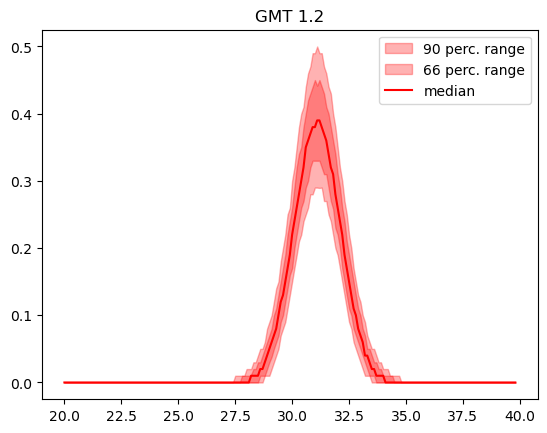

In [26]:
gmt = 1.2
bins = np.arange(20., 40., 0.1)
x = bins[1:] - np.diff(bins,1)
dstrs = xr.DataArray(dims=['nBoot','x'], coords=dict(nBoot=np.arange(N_boot), x=x))
for i in range(N_boot):
    dstr = dstr_obj()
    dstr.store_parameters(popts.loc[i].values)
    d = dstr.distr_for_given_gmt(gmt, N=1000)
    pdf,bins = np.histogram(d, bins=bins, density=True)
    dstrs.loc[i] = pdf

prctls_parametric = np.nanpercentile(dstrs, [0,5,17,50,83,95,100], axis=0)

plt.title('GMT %s' %(gmt))
plt.fill_between(x, prctls_parametric[1,:], prctls_parametric[-2,:], alpha=0.3, color='r', label='90 perc. range')
plt.fill_between(x, prctls_parametric[2,:], prctls_parametric[-3,:], alpha=0.3, color='r', label='66 perc. range')
plt.plot(x, prctls_parametric[3,:], color='r', label='median')
plt.legend()

### Compare to time slicing
For time slicing I also implemented some kind of bootstrapping:\
10 random slices are selected to form one distribution. This is repeated 1000 times

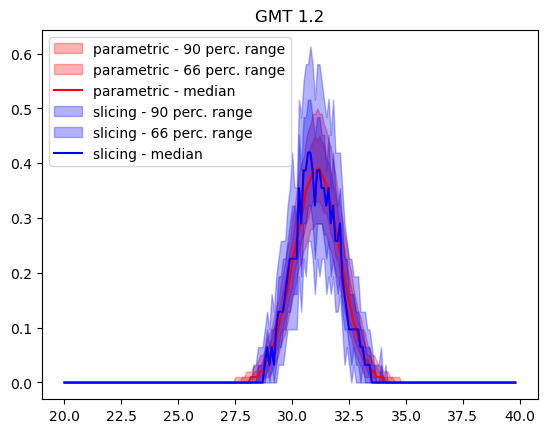

In [28]:
slicing_window = 31
hsw = int(slicing_window/2)
number_of_slices = 10
ids,years = np.where(np.abs(rev._gmt_smoo - gmt) < 0.05)
slices = xr.DataArray(dims=['i','year'], coords=dict(i=np.arange(len(ids)), year=np.arange(slicing_window)))
for i in slices.i.values:
    slices.loc[i] = x2D.values[ids[i],years[i]-hsw:years[i]+hsw+1]
    
dstrs = xr.DataArray(dims=['nBoot','x'], coords=dict(nBoot=np.arange(N_boot), x=x))
for i in np.arange(N_boot):
    sel_i = np.random.choice(slices.shape[0], number_of_slices, replace=False)
    d = slices.loc[sel_i].values.flatten()
    pdf,bins = np.histogram(d, bins=bins, density=True)
    dstrs.loc[i] = pdf
    
prctls_slicing = np.nanpercentile(dstrs, [0,5,17,50,83,95,100], axis=0)

plt.title('GMT %s' %(gmt))
plt.fill_between(x, prctls_parametric[1,:], prctls_parametric[-2,:], alpha=0.3, color='r', label='parametric - 90 perc. range')
plt.fill_between(x, prctls_parametric[2,:], prctls_parametric[-3,:], alpha=0.3, color='r', label='parametric - 66 perc. range')
plt.plot(x, prctls_parametric[3,:], color='r', label='parametric - median')

plt.fill_between(x, prctls_slicing[1,:], prctls_slicing[-2,:], alpha=0.3, color='b', label='slicing - 90 perc. range')
plt.fill_between(x, prctls_slicing[2,:], prctls_slicing[-3,:], alpha=0.3, color='b', label='slicing - 66 perc. range')
plt.plot(x, prctls_slicing[3,:], color='b', label='slicing - median')
plt.legend()

## Reversal: At which GMT level will an impact threhsold be exceeded every 10th year?
event definition:\
1 in 100 year event in a 1.2 GMT climate

In [29]:
# event definition: 1 in 100 year event in a 1.2 GMT climate
gmt = 1.2
dstr = dstr_obj()
dstr.store_parameters(popts.mean('nBoot').values)
d = dstr.distr_for_given_gmt(gmt, N=100000)
threshold = np.nanpercentile(d, 99.)
print(threshold)

33.53739995691016


In [30]:
N_boot = 1000
pctls_d = {}
for slicing_window in [11, 21, 31]:
    hsw = int(slicing_window/2)
    pctls_d['slicing_%s' %(slicing_window)] = xr.DataArray(dims=['gmt','i'], coords=dict(i=np.arange(N_boot), gmt=np.arange(1.5,3.0,0.05)))
    for gmt in pctls_d['slicing_%s' %(slicing_window)].gmt.values:
        ids,years = np.where(np.abs(gmt2D - gmt) < 0.05)
        slices = xr.DataArray(dims=['i','year'], coords=dict(i=np.arange(len(ids)), year=np.arange(slicing_window)))
        for i in slices.i.values:
            slices.loc[i] = x2D.values[ids[i],years[i]-hsw:years[i]+hsw+1]
        for i in pctls_d['slicing_%s' %(slicing_window)].i.values:
            sel_i = np.random.choice(slices.shape[0], int(slices.shape[0]/10), replace=False)
            d = slices.loc[sel_i].values.flatten()
            pctls_d['slicing_%s' %(slicing_window)].loc[gmt,i] = percentileofscore(d, threshold)

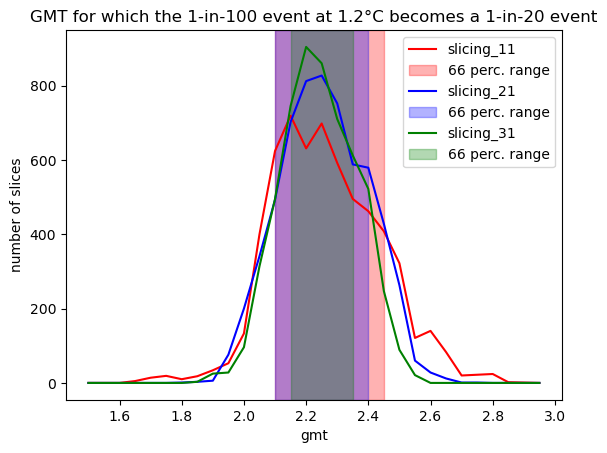

In [31]:
plt.title('GMT for which the 1-in-100 event at 1.2°C becomes a 1-in-20 event')
plt.ylabel('number of slices')
plt.xlabel('gmt')
for slicing_window,color in zip([11, 21, 31],['r','b','g']):
    counts = (np.abs(pctls_d['slicing_%s' %(slicing_window)] - 95) < 1).sum('i')
    plt.plot(counts.gmt,counts, color=color, label='slicing_%s' %(slicing_window))
    plt.axvspan(counts.gmt[np.where(np.cumsum(counts) > 0.17 * np.sum(counts))[0][0]], 
                counts.gmt[np.where(np.cumsum(counts) > 0.83 * np.sum(counts))[0][0]], 
                alpha=0.3, color=color, label='66 perc. range')
plt.legend()

In [32]:
gmts = xr.DataArray(dims=['nBoot'], coords=dict(nBoot=np.arange(N_boot)))
for i in range(N_boot):
    dstr = dstr_obj()
    dstr.store_parameters(popts.loc[i].values)
    gmts.loc[i] = dstr.reversal_function(threshold, 0.95)

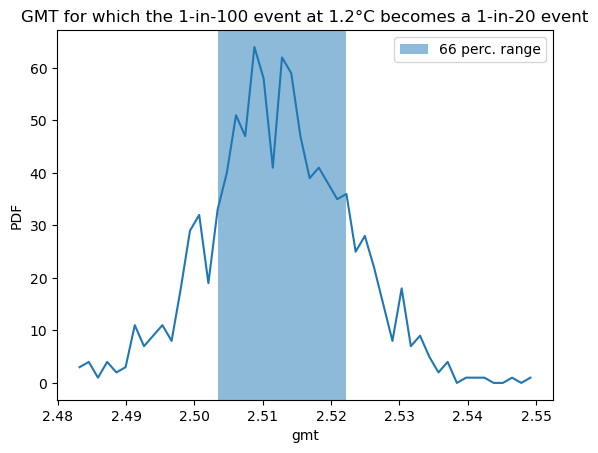

In [33]:
plt.close()
plt.title('GMT for which the 1-in-100 event at 1.2°C becomes a 1-in-20 event')
plt.ylabel('PDF')
plt.xlabel('gmt')
pdf,bins = np.histogram(gmts.values, bins=50, density=False)
x = bins[1:] - np.diff(bins,1)
plt.axvspan(x[np.where(np.cumsum(pdf) > 0.17 * np.sum(pdf))[0][0]], x[np.where(np.cumsum(pdf) > 0.83 * np.sum(pdf))[0][0]],
            alpha=0.5, label='66 perc. range')
plt.plot(x,pdf)
plt.legend()

Text(0.5, 0, 'gmt')

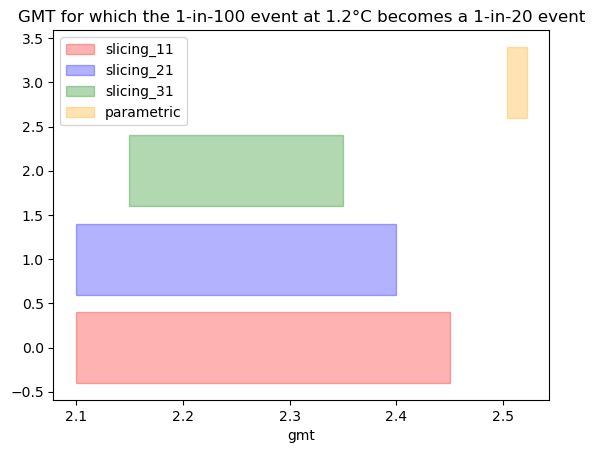

In [34]:
plt.title('GMT for which the 1-in-100 event at 1.2°C becomes a 1-in-20 event')
for slicing_window,color,y in zip([11, 21, 31],['r','b','g'],[0,1,2]):
    counts = (np.abs(pctls_d['slicing_%s' %(slicing_window)] - 95) < 1).sum('i')
    plt.fill_between([counts.gmt[np.where(np.cumsum(counts) > 0.17 * np.sum(counts))[0][0]], 
                counts.gmt[np.where(np.cumsum(counts) > 0.83 * np.sum(counts))[0][0]],], [y-0.4]*2, [y+0.4]*2,
                alpha=0.3, color=color, label='slicing_%s' %(slicing_window))
plt.fill_between([x[np.where(np.cumsum(pdf) > 0.17 * np.sum(pdf))[0][0]], 
                  x[np.where(np.cumsum(pdf) > 0.83 * np.sum(pdf))[0][0]]], [3-0.4]*2, [3+0.4]*2,
                alpha=0.3, color='orange', label='parametric')
plt.legend(loc='upper left')
plt.xlabel('gmt')